In [29]:
!pip -q install --upgrade openai mistralai transformers torch scipy numpy regex matplotlib python-dotenv pyyaml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 566.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [31]:
import os, json, re, random, time, regex as rx, numpy as np, matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from dataclasses import dataclass
from tqdm.auto import tqdm
from scipy.stats import pearsonr, spearmanr
import torch


In [32]:
os.environ["MISTRAL_API_KEY"] = TODO

# general settings
USE_MISTRAL_FOR_GENERATION = True
N_GENERATE = 200
MAX_EVAL = 100
RUN_IDENTITY = True
RUN_MISTRAL_REWRITE = True
RUN_BERT_REWRITE = True
DATA_PATH = "/content/mistral_en_zh.jsonl"
SEED = 7
random.seed(SEED); np.random.seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cpu'

In [33]:
from openai import OpenAI

if not os.getenv("MISTRAL_API_KEY"):
    raise RuntimeError("Set MISTRAL_API_KEY first!")

_mistral_client = OpenAI(
    api_key=os.environ["MISTRAL_API_KEY"],
    base_url="https://api.mistral.ai/v1",
)

def mistral_chat(prompt: str,
                 model="mistral-large-latest",
                 temperature=0.7,
                 max_tokens=512) -> str:
    resp = _mistral_client.chat.completions.create(
        model=model,
        messages=[{"role":"user","content":prompt}],
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return resp.choices[0].message.content

def make_switch_prompt(topic="general", cs_ratio="50%", cs_type="Intersentential"):
    return f"""You are generating English–Chinese (Mandarin) code-switching utterances.

Requirements:
- Topic/domain: {topic}
- Code-switching type: {cs_type}
- Target embedded ratio: {cs_ratio} Chinese words overall (approximate)
- Naturalness: obey linguistic constraints, stay idiomatic in both languages.
- Output exactly 3 short sentences (each on its own line), no commentary."""


In [34]:
CHECKPOINT_PATH = "/content/mistral_en_zh_ckpt.jsonl"

def generate_en_zh_samples(n=200,
                           topics=("general","technology","sports"),
                           ratios=("30%","50%","70%"),
                           cs_types=("Intersentential","Intrasentential"),
                           model="mistral-large-latest",
                           temperature=0.7,
                           checkpoint_every=50,
                           seed=7) -> List[Dict]:
    random.seed(seed)
    rows = []
    ok, skipped = 0, 0

    # resume if checkpoint exists
    if os.path.exists(CHECKPOINT_PATH):
        with open(CHECKPOINT_PATH,"r",encoding="utf-8") as f:
            for line in f:
                try: rows.append(json.loads(line))
                except: pass
        start_i = len(rows)
    else:
        start_i = 0

    pbar = tqdm(total=n, desc="Generating EN–ZH", initial=start_i)
    for i in range(start_i, n):
        t0 = time.time()
        t   = random.choice(topics)
        r   = random.choice(ratios)
        cst = random.choice(cs_types)
        prompt = make_switch_prompt(topic=t, cs_ratio=r, cs_type=cst)

        try:
            text = mistral_chat(prompt, model=model,
                                temperature=temperature, max_tokens=400)
            lines = [s.strip() for s in text.split("\n") if s.strip()]
            if len(lines) > 3: lines = lines[-3:]
            if not lines: raise ValueError("empty output")

            row = {
                "topic": t, "cs_ratio": r, "cs_type": cst,
                "first_language": "English", "second_language": "Chinese",
                "data_generation_result": lines
            }
            rows.append(row)
            ok += 1
            if (i+1) % checkpoint_every == 0:
                with open(CHECKPOINT_PATH,"w",encoding="utf-8") as f:
                    for rr in rows:
                        f.write(json.dumps(rr,ensure_ascii=False)+"\n")
        except Exception:
            skipped += 1

        dt = time.time()-t0
        pbar.set_postfix(ok=ok,skip=skipped,sec=f"{dt:.2f}")
        pbar.update(1)
    pbar.close()

    with open(DATA_PATH,"w",encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r,ensure_ascii=False)+"\n")

    return rows

def load_jsonl(path):
    data=[]
    with open(path,"r",encoding="utf-8") as f:
        for l in f:
            l=l.strip()
            if l: data.append(json.loads(l))
    return data

if USE_MISTRAL_FOR_GENERATION:
    entries = generate_en_zh_samples(n=N_GENERATE)
else:
    entries = load_jsonl(DATA_PATH)

print(f"Loaded {len(entries)} entries"); print(entries[0])


Generating EN–ZH:   0%|          | 0/200 [00:00<?, ?it/s]

Loaded 200 entries
{'topic': 'technology', 'cs_ratio': '30%', 'cs_type': 'Intrasentential', 'first_language': 'English', 'second_language': 'Chinese', 'data_generation_result': ['1. My phone 突然 **black screen** 了，我试了 **hard reset** 还是没用，真 **头大**！', '2. 这个新 **AI model** 的 **accuracy** 超高，但 **training data** 太 **贵** 了，公司可能 **load** 不动。', '3. You 要 **upgrade** 你的 **GPU** 才能跑这款游戏，不然 **fps** 会 **掉得很惨**，真的 **不值**。']}


In [39]:
punct_pat = rx.compile(r"^\p{P}+$")
num_pat   = rx.compile(r"^\p{N}+$")
emoji_pat = rx.compile(r"\p{Emoji}")
url_pat   = re.compile(r"https?://|www\.|\.((com|net|org|cn|hk|tw|io|ai)(/|$))", re.I)

def is_other(tok):
    return (not tok or punct_pat.match(tok) or num_pat.match(tok)
            or emoji_pat.search(tok) or url_pat.search(tok))

def token_lang(tok):
    if is_other(tok): return "other"
    if rx.search(r"\p{Han}", tok): return "zh"
    if rx.search(r"\p{Latin}", tok): return "en"
    return "other"

def tag_sentence(text):
    return [(t, token_lang(t)) for t in text.split()]

CONTENT_EXCLUDE = {"other"}

def cmi_from_tags(tags: List[Tuple[str,str]]) -> float:
    langs = [l for _,l in tags if l not in CONTENT_EXCLUDE]
    if len(langs) <= 1: return 0.0
    _, counts = np.unique(langs, return_counts=True)
    return 100.0 * (1.0 - counts.max()/counts.sum())

def join_generation_text(e: Dict) -> str:
    arr = e.get("data_generation_result", [])
    return " ".join(arr) if isinstance(arr, list) else str(arr)


In [40]:
import math

def parse_computed_ratio(s: str):
    nums = re.findall(r"(\d+(?:\.\d+)?)\s*%", s or "")
    if len(nums) >= 2:
        a = float(nums[0]); b = float(nums[1])
        if a + b > 0:
            return a/100.0, b/100.0
    return None

def parse_requested_ratio(s: str):
      m = re.search(r"(\d+(?:\.\d+)?)\s*%", s or "")
    if m:
        p = float(m.group(1))/100.0
        # interpret as embedded share; expected-2lang CMI=1-max(p,1-p)
        return p, 1.0 - p
    return None

def expected_cmi_from_ratio_pair(p1: float, p2: float) -> float:
    # for two languages only; Das & Gambäck CMI in [0,100]
    total = p1 + p2
    if total <= 0: return 0.0
    p1 /= total; p2 /= total
    return 100.0 * (1.0 - max(p1, p2))

def get_expected_cmi(entry: Dict) -> float:
    # priority 1: empirical computed_ratio if present
    cr = entry.get("cs_ratio_result", {}).get("computed_ratio", None)
    if cr:
        pair = parse_computed_ratio(cr)
        if pair:
            return expected_cmi_from_ratio_pair(*pair)
    # priority 2: requested target in "cs_ratio" (e.g., "30%")
    req = entry.get("cs_ratio", None)
    if req:
        pair = parse_requested_ratio(req)
        if pair:
            return expected_cmi_from_ratio_pair(*pair)
    return float("nan")


In [41]:
xs_actual_cmi = []
ys_expected_cmi = []

for e in entries:
    text = join_generation_text(e)
    actual = cmi_from_tags(tag_sentence(text))
    expected = get_expected_cmi(e)
    if not math.isnan(expected):
        xs_actual_cmi.append(actual)
        ys_expected_cmi.append(expected)

len(xs_actual_cmi), len(ys_expected_cmi)


(200, 200)

Pairs: 200
Pearson(actual CMI vs expected CMI) = 0.178 (p=0.0115)
Spearman(actual CMI vs expected CMI) = 0.246 (p=0.000446)
Mean actual CMI = 12.55
Mean expected CMI = 36.50


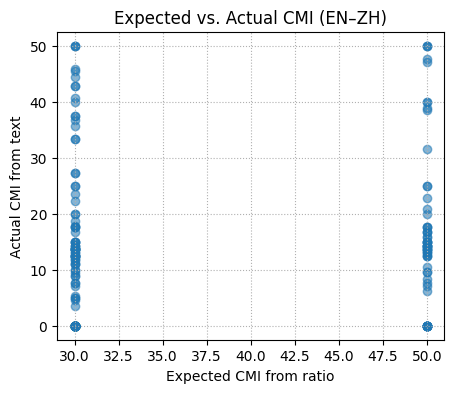

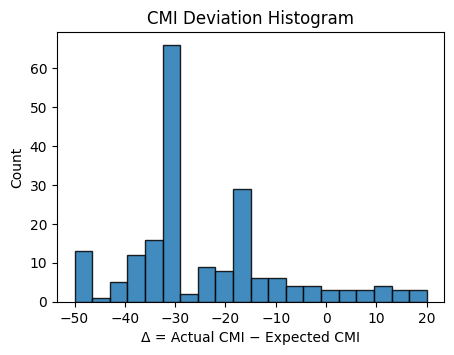

In [42]:
from scipy.stats import pearsonr, spearmanr
import numpy as np
import matplotlib.pyplot as plt

if len(xs_actual_cmi) >= 2:
    r, p = pearsonr(xs_actual_cmi, ys_expected_cmi)
    rs, ps = spearmanr(xs_actual_cmi, ys_expected_cmi)
    print(f"Pairs: {len(xs_actual_cmi)}")
    print(f"Pearson(actual CMI vs expected CMI) = {r:.3f} (p={p:.3g})")
    print(f"Spearman(actual CMI vs expected CMI) = {rs:.3f} (p={ps:.3g})")
    print(f"Mean actual CMI = {np.mean(xs_actual_cmi):.2f}")
    print(f"Mean expected CMI = {np.mean(ys_expected_cmi):.2f}")

    plt.figure(figsize=(5,4))
    plt.scatter(ys_expected_cmi, xs_actual_cmi, alpha=0.55)
    plt.xlabel("Expected CMI from ratio")
    plt.ylabel("Actual CMI from text")
    plt.title("Expected vs. Actual CMI (EN–ZH)")
    plt.grid(True, ls=":")
    plt.show()

    delta = np.array(xs_actual_cmi) - np.array(ys_expected_cmi)
    plt.figure(figsize=(5,3.5))
    plt.hist(delta, bins=20, edgecolor="black", alpha=0.85)
    plt.xlabel("Δ = Actual CMI − Expected CMI")
    plt.ylabel("Count")
    plt.title("CMI Deviation Histogram")
    plt.show()
else:
    print("Not enough pairs with usable ratios to compute correlations.")


# Generation

In [43]:
DATA_PATH = "/content/sample_data/mistral_en_zh.jsonl"
MAX_EVAL  = 150
SEED = 7
random.seed(SEED); np.random.seed(SEED)

import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [44]:
from openai import OpenAI
if not os.getenv("MISTRAL_API_KEY"): raise RuntimeError("Set MISTRAL_API_KEY.")
_mistral = OpenAI(api_key=os.environ["MISTRAL_API_KEY"],
                  base_url="https://api.mistral.ai/v1")

def mistral_chat(prompt: str, model="mistral-large-latest", temperature=0.7, max_tokens=300) -> str:
    resp = _mistral.chat.completions.create(
        model=model,
        messages=[{"role":"user","content":prompt}],
        temperature=temperature, max_tokens=max_tokens,
    )
    return resp.choices[0].message.content

def make_response_prompt(user_text: str) -> str:
    return f"""You are chatting with a bilingual user.
Read the user's message and **reply naturally** in 1–2 sentences.
- Do NOT quote or rewrite their text.
- Keep the topic.
- Use whichever language(s) feel natural given the user’s message (English/Chinese), matching the vibe.

User: {user_text}
Assistant:"""

class MistralResponder:
    def __init__(self, model="mistral-large-latest", temperature=0.7):
        self.model=model; self.temperature=temperature
    def generate(self, text: str) -> str:
        out = mistral_chat(make_response_prompt(text), model=self.model, temperature=self.temperature)
        # keep it tidy
        lines = [s.strip() for s in out.split("\n") if s.strip()]
        return " ".join(lines[:2])

from transformers import AutoTokenizer, EncoderDecoderModel
class BertResponder:

    def __init__(self, name="bert-base-multilingual-cased", max_len=96, device=DEVICE):
        self.tok = AutoTokenizer.from_pretrained(name)
        self.model = EncoderDecoderModel.from_encoder_decoder_pretrained(name, name)
        self.model.to(device).eval(); self.max_len=max_len; self.device=device

    @torch.inference_mode()
    def generate(self, text: str) -> str:
        # prefix nudges it to produce something like a reply
        prompt = f"User: {text}\nAssistant:"
        enc = self.tok(prompt, return_tensors="pt", truncation=True, max_length=256).to(self.device)
        out = self.model.generate(**enc, max_length=self.max_len, num_beams=3)
        resp = self.tok.decode(out[0], skip_special_tokens=True)
        # post-trim common echoes
        resp = resp.replace("User:", "").replace("Assistant:", "").strip()
        return resp


In [45]:
from tqdm.auto import tqdm
from dataclasses import dataclass
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

@dataclass
class EvalOut:
    n:int
    pearson_r:float; pearson_p:float
    spearman_r:float; spearman_p:float
    mean_in:float; mean_out:float

def eval_model(entries, generator, limit=150, csv_path=None, title=""):
    xs, ys = [], []
    rows = []
    for e in tqdm(entries[:limit], desc=f"Evaluating {title}"):
        src = join_generation_text(e)
        x = cmi_from_tags(tag_sentence(src))
        hyp = generator.generate(src)
        y = cmi_from_tags(tag_sentence(hyp))
        xs.append(x); ys.append(y)
        rows.append({"input_text":src, "output_text":hyp, "input_cmi":x, "output_cmi":y, "delta": y-x})

    # correlations
    if len(xs) >= 2:
        r, p  = pearsonr(xs, ys)
        rs, ps = spearmanr(xs, ys)
    else:
        r=p=rs=ps=float("nan")

    # plots
    plt.figure(figsize=(5,4))
    plt.scatter(xs, ys, alpha=0.55)
    plt.xlabel("Input CMI"); plt.ylabel("Output CMI")
    plt.title(f"{title}: Pearson={r:.2f}")
    plt.grid(True, ls=":")
    plt.show()

    import numpy as np
    d = np.array(ys) - np.array(xs)
    plt.figure(figsize=(5,3.5))
    plt.hist(d, bins=20, edgecolor="black", alpha=0.85)
    plt.xlabel("ΔCMI = out − in"); plt.ylabel("Count")
    plt.title(f"{title}: ΔCMI histogram")
    plt.show()

    # optional CSV
    if csv_path and rows:
        import csv
        with open(csv_path, "w", encoding="utf-8", newline="") as f:
            w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
            w.writeheader()
            for rrow in rows: w.writerow(rrow)

    return EvalOut(
        n=len(xs),
        pearson_r=float(r), pearson_p=float(p),
        spearman_r=float(rs), spearman_p=float(ps),
        mean_in=float(np.mean(xs)), mean_out=float(np.mean(ys))
    )


▶ Mistral respond (no rewrite)


Mistral Respond:   0%|          | 0/150 [00:00<?, ?it/s]

⚠️ API error at 25: Error code: 429 - {'object': 'error', 'message': 'Service tier capacity exceeded for this model.', 'type': 'service_tier_capacity_exceeded', 'param': None, 'code': '3505'}


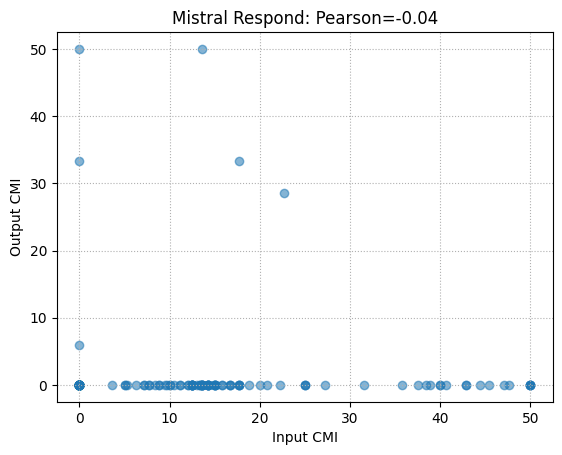

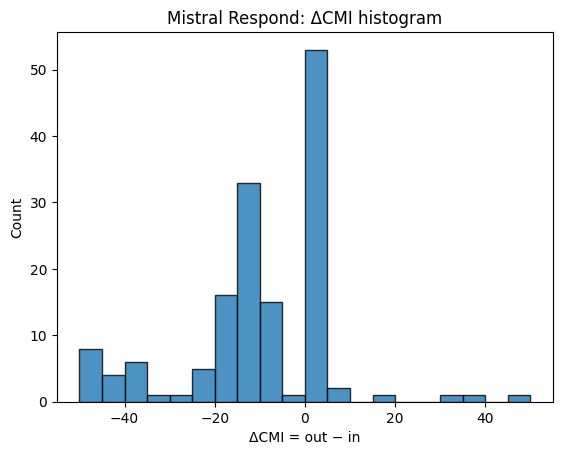

TypeError: float() argument must be a string or a real number, not 'dict'

In [49]:
import os, json, time
from tqdm.auto import tqdm

CKPT_PATH = "/content/mistral_respond_ckpt.jsonl"

def mistral_eval_with_checkpoint(entries, generator, limit=MAX_EVAL,
                                 csv_path="/content/mistral_respond_pairs.csv",
                                 title="Mistral Respond", checkpoint_every=10):
    start = 0
    rows = []

    # resume from checkpoint if exists
    if os.path.exists(CKPT_PATH):
        with open(CKPT_PATH, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    rows.append(json.loads(line))
                except:
                    pass
        start = len(rows)
        print(f"⚙️ Resuming from checkpoint: {start} items already done")

    n = min(limit, len(entries))
    pbar = tqdm(total=n, desc=title, initial=start)

    for i in range(start, n):
        e = entries[i]
        src = join_generation_text(e)
        x = cmi_from_tags(tag_sentence(src))
        try:
            hyp = generator.generate(src)
        except Exception as ex:
            print(f"⚠️ API error at {i}: {ex}")
            time.sleep(3)
            continue
        y = cmi_from_tags(tag_sentence(hyp))

        row = {"i": i, "input_text": src, "output_text": hyp,
               "input_cmi": x, "output_cmi": y, "delta": y - x}
        rows.append(row)

        # checkpoint save
        if (i + 1) % checkpoint_every == 0 or (i + 1) == n:
            with open(CKPT_PATH, "w", encoding="utf-8") as f:
                for r in rows:
                    f.write(json.dumps(r, ensure_ascii=False) + "\n")

        pbar.set_postfix(done=len(rows))
        pbar.update(1)

    pbar.close()

    # final correlation + plots
    xs = [r["input_cmi"] for r in rows]
    ys = [r["output_cmi"] for r in rows]

    from scipy.stats import pearsonr, spearmanr
    r, p = pearsonr(xs, ys) if len(xs) > 1 else (float("nan"), float("nan"))
    rs, ps = spearmanr(xs, ys) if len(xs) > 1 else (float("nan"), float("nan"))

    import matplotlib.pyplot as plt, numpy as np
    plt.scatter(xs, ys, alpha=0.55)
    plt.xlabel("Input CMI"); plt.ylabel("Output CMI")
    plt.title(f"{title}: Pearson={r:.2f}")
    plt.grid(True, ls=":")
    plt.show()

    delta = np.array(ys) - np.array(xs)
    plt.hist(delta, bins=20, edgecolor="black", alpha=0.8)
    plt.xlabel("ΔCMI = out − in"); plt.ylabel("Count")
    plt.title(f"{title}: ΔCMI histogram")
    plt.show()

    # export CSV
    if csv_path:
        import csv
        with open(csv_path, "w", encoding="utf-8", newline="") as f:
            w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
            w.writeheader()
            for r in rows: w.writerow(r)

    from dataclasses import dataclass
    @dataclass
    class EvalOut:
        n:int; pearson_r:float; pearson_p:float; spearman_r:float; spearman_p:float
        mean_in:float; mean_out:float
    return EvalOut(len(xs), float(r), float(p), float(rs), float(ps),
                   float(np.mean(xs)), float(np.mean(ys)))

print("▶ Mistral respond (no rewrite)")
mistral = MistralResponder(model="mistral-large-latest", temperature=0.7)
res_mis = mistral_eval_with_checkpoint(entries, mistral,
                                       limit=MAX_EVAL,
                                       csv_path="/content/mistral_respond_pairs.csv",
                                       title="Mistral Respond")
results["mistral_respond"] = res_mis
print(vars(res_mis))


In [50]:
from transformers import AutoTokenizer, EncoderDecoderModel
import torch

class BertResponder:

    def __init__(self, name="bert-base-multilingual-cased", max_len=96, device=DEVICE):
        self.tok   = AutoTokenizer.from_pretrained(name)
        self.model = EncoderDecoderModel.from_encoder_decoder_pretrained(name, name)
        self.model.to(device).eval()
        self.max_len = max_len
        self.device  = device

        bos_id = self.tok.cls_token_id
        eos_id = self.tok.sep_token_id
        pad_id = self.tok.pad_token_id if self.tok.pad_token_id is not None else self.tok.unk_token_id

        # set on both model and tokenizer to be safe
        self.model.config.decoder_start_token_id = bos_id
        self.model.config.eos_token_id           = eos_id
        self.model.config.pad_token_id           = pad_id
        self.tok.pad_token_id                    = pad_id

        print("[BERT2BERT] ids:",
              "decoder_start", self.model.config.decoder_start_token_id,
              "| eos", self.model.config.eos_token_id,
              "| pad", self.model.config.pad_token_id)

    @torch.inference_mode()
    def generate(self, text: str) -> str:
        prompt = f"User: {text}\nAssistant:"
        enc = self.tok(prompt, return_tensors="pt", truncation=True, max_length=256).to(self.device)
        out = self.model.generate(
            **enc,
            max_length=self.max_len,
            num_beams=3,
            decoder_start_token_id=self.model.config.decoder_start_token_id,
            eos_token_id=self.model.config.eos_token_id,
            pad_token_id=self.model.config.pad_token_id,
            no_repeat_ngram_size=3,
        )
        resp = self.tok.decode(out[0], skip_special_tokens=True)
        # tidy common echoes
        resp = resp.replace("User:", "").replace("Assistant:", "").strip()
        return resp if resp else "Okay."


▶ BERT respond (very weak baseline)


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bia

[BERT2BERT] ids: decoder_start 101 | eos 102 | pad 0


Evaluating BERT Respond:   0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipython-input-3294438176.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p  = pearsonr(xs, ys)
/tmp/ipython-input-3294438176.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rs, ps = spearmanr(xs, ys)


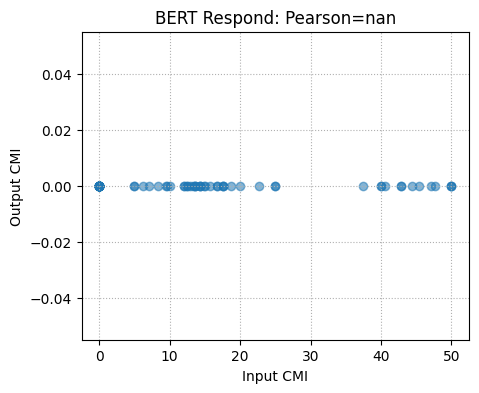

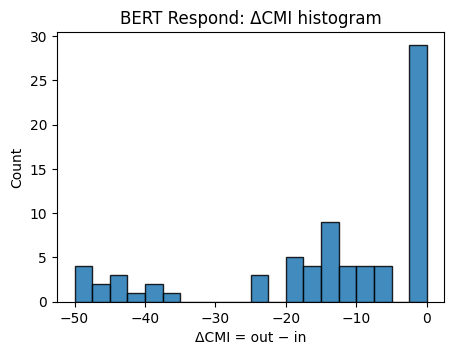

{'n': 75, 'pearson_r': nan, 'pearson_p': nan, 'spearman_r': nan, 'spearman_p': nan, 'mean_in': 13.89041643012365, 'mean_out': 0.0}


In [51]:
print("▶ BERT respond (very weak baseline)")
bert = BertResponder()
res_bert = eval_model(
    entries, bert,
    limit=max(50, MAX_EVAL//2),
    csv_path="/content/bert_respond_pairs.csv",
    title="BERT Respond"
)
results["bert_respond"] = res_bert
print(vars(res_bert))
